<a href="https://colab.research.google.com/github/Ghonem22/Egyptian-Currency-Detection-using-YoloV5/blob/main/Egyptian_Banknotes_classifier_using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Indian Dishes Classifier

In [2]:
# we’ll be using it to import Efficientnet-B2.
!pip install geffnet

     |████████████████████████████████| 40 kB 3.3 MB/s 


### **Import Necessary Libraries:**

In [4]:
import numpy as np
import pandas as pd
import glob
import math
import os
import torch
import random
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import shutil
import zipfile

import geffnet

In [5]:
!nvidia-smi

Thu Oct 21 14:47:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# For mounting Google drive, as I was using Google Collab and my Dataset was in Google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
# Create a ZipFile Object and load sample.zip in it\
from zipfile import ZipFile 
with ZipFile('/content/drive/MyDrive/Currency_Data/Egyptian_Currency.zip', 'r') as zipObj:
# Extract all the contents of zip file in current directory
    zipObj.extractall()


In [7]:
shutil.move("/content/content/Egyptian_Currency","/content/")


'/content/Egyptian_Currency'

In [8]:
# Get the total number of images in each class
file_count = 0
classes = os.listdir("/content/Egyptian_Currency/valid/")
for cat in ['train', 'valid']:
  files = glob.glob('/content/Egyptian_Currency/'+cat+'/*/*')
  print(cat,'Images:',len(files), end = ', ')
print('\n')
for direc in classes:
  files = glob.glob('/content/Egyptian_Currency/*/'+direc+'/*')
  file_count += len(files)
  print(direc, len(files))
print(file_count)

train Images: 67680, valid Images: 5723, 

5B 6118
100F 6180
200F 6212
50F 6101
50B 6067
10B 6088
10F 6109
20F 6042
5F 6183
20B 5995
100B 6127
200B 6181
73403


In [9]:
data_dir = '/content/Egyptian_Currency/'
random.seed(41)



## **Load The Data**

we’ll be using RandomRotation, RandomPerspective, RandomHorizontalFlip, Resize all the image to 224x224, convert them to Tensors and finally normalizing images with Imagenet Pretrained Stats.


In [10]:
#Data Tranforms (Augmentation and Normalization)
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomPerspective(distortion_scale=0.4),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(0.6),
                                       transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

#Getting all the data with PyTorch Datasets
train_data = datasets.ImageFolder(data_dir + '/train', transform= train_transforms)
val_data = datasets.ImageFolder(data_dir + '/valid', transform= val_transforms)
test_data = datasets.ImageFolder('/content/drive/MyDrive/Currency/test', transform= test_transforms)

#Loading the data into PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size= 64, shuffle = True,num_workers=2)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size= 64, shuffle = True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size= 64, shuffle = True,num_workers=2)

#Creating a dictionary of all classes
classes = dict(zip(list(range(len(train_data.classes))),train_data.classes))

In [11]:
classes

{0: '100B',
 1: '100F',
 2: '10B',
 3: '10F',
 4: '200B',
 5: '200F',
 6: '20B',
 7: '20F',
 8: '50B',
 9: '50F',
 10: '5B',
 11: '5F'}

### **Check the images with labels**

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

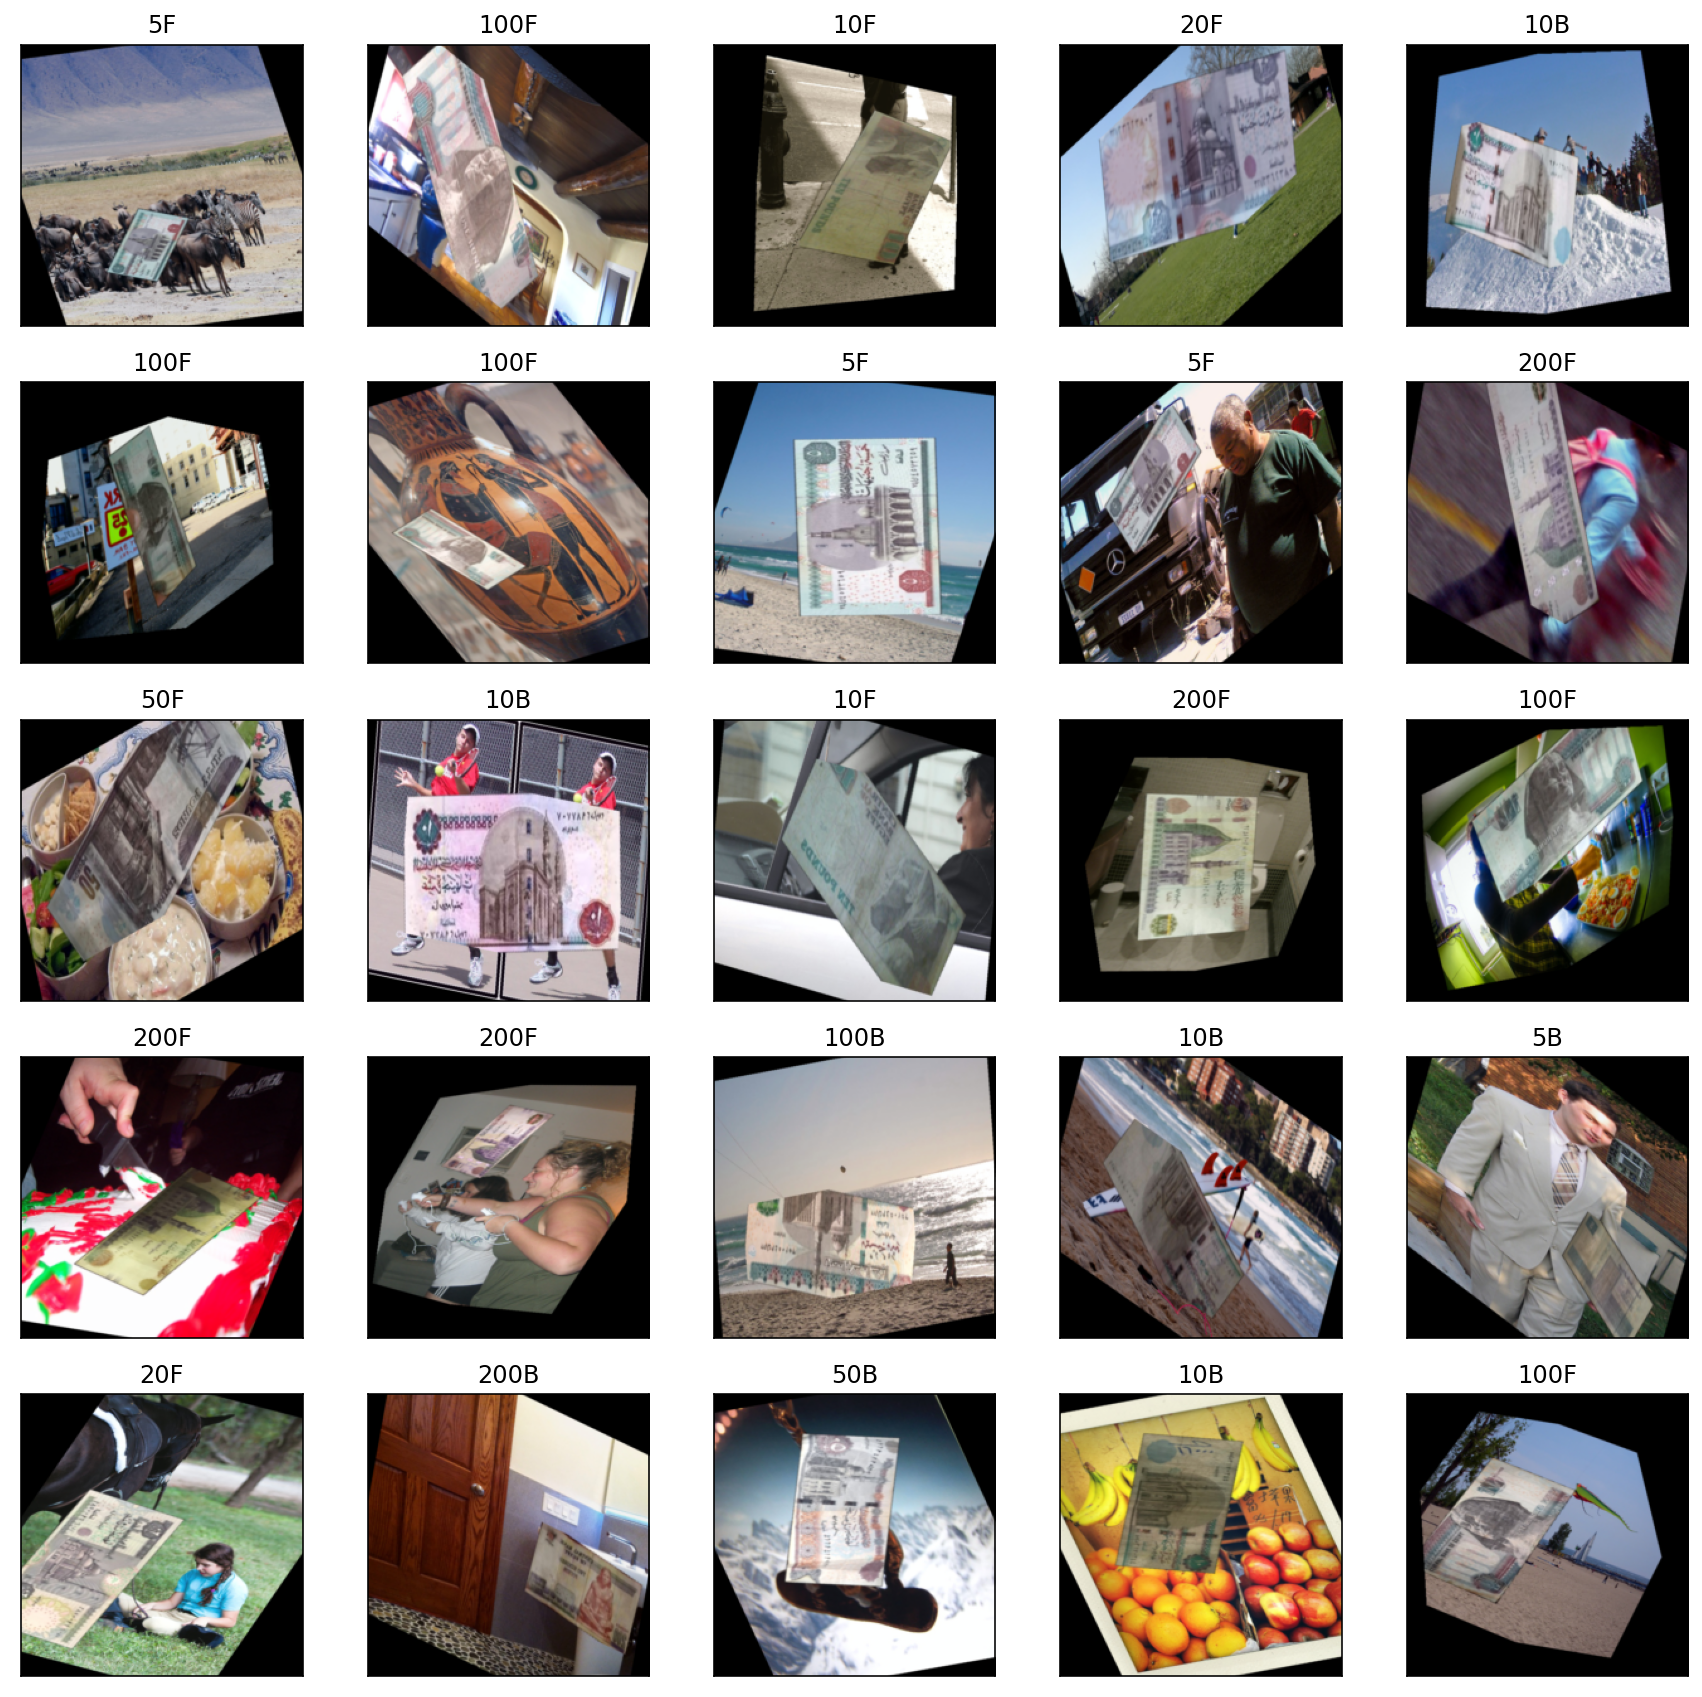

In [12]:
def denormalise(image):
  try:
    image = image.cpu().numpy().transpose(1, 2, 0)
  except:
    image = image.transpose(1, 2, 0) # PIL images have channel last
  mean = [0.485, 0.456, 0.406]
  stdd = [0.229, 0.224, 0.225]
  image = (image * stdd + mean).clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(15,15))

for idx in np.arange(25):
  ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(denormalise(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx].item()])

## **Load the model**

In [13]:
# Specify the device type
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
# Loading the model
model = geffnet.create_model('efficientnet_b2', pretrained=True)

# Freezing all the layers
for param in model.parameters():
  param.requires_grad = False

# Changing the Classifier
model.classifier = nn.Sequential(nn.Linear(1408,512),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(512,128),
                           nn.ReLU(),
                           nn.Dropout(p=0.4),
                           nn.Linear(128,len(classes)))

# Making the Classifier layer Trainable                           
for param in model.classifier.parameters():
  param.requires_grad = True

# Moving the model to device
model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b2_ra-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_ra-bcdf34b7.pth


GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwise

### **Specify the Loss Criterion, Optimizer and Scheduler**

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.classifier.parameters(),lr = 0.01)
scheduler = StepLR(optimizer, step_size=6, gamma=0.35)

## **Train The Model**

In [ ]:
epochs = 20 # Number of epochs
steps = 0
print_every = 5 
train_losses, valid_losses,valid_acc = [], [], [] # List keeping track of losses and accuracy to plot later
valid_loss_min = np.Inf # It will be used to save model whenever Vallidation loss decreases
valid_acc_min = 0.0 

for e in range(epochs):
  
  train_loss = 0 
  model.train()
  #train the model
  for images, labels in train_loader:
    steps+=1
    # Move tensor to device('cuda' in case of GPU or 'cpu' in case of CPU)
    images, labels = images.to(device), labels.to(device)
    # Clearing all the previous gradients
    optimizer.zero_grad()
    # Forward Pass
    logits = model(images)
    # Loss calculation
    loss = criterion(logits,labels)
    # Backward Pass
    loss.backward()
    # Update the parameters
    optimizer.step()
    # Updating the losses list
    train_loss += loss.item()

    # Evaluating after specific amount of steps
    if steps % print_every == 0:
      valid_loss = 0
      accuracy = 0
      # Setting Model to Evaluation Mode
      model.eval()
      with torch.no_grad():
        # Getting Validation loss
        for images, labels in valid_loader:
          images, labels = images.to(device), labels.to(device)
          logits = model(images)
          batch_loss = criterion(logits,labels)
          valid_loss += batch_loss.item()
          
          # Calculating Accuracy
          output = F.softmax(logits,dim=1)
          top_p,top_class = output.topk(1,dim = 1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      # Printing stats    
      print(f"Epoch {e+1}/{epochs}.. "
                  f"Train loss: {train_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(valid_loader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(valid_loader):.3f}.. "
                  f"LR : {scheduler.get_lr():}"
                  )
      valid_loss = valid_loss/len(valid_loader)
      train_losses.append(train_loss/print_every)
      valid_losses.append(valid_loss)
      valid_acc.append(accuracy/len(valid_loader))
      
      # Checking if Validation loss decreased
      if valid_loss <= valid_loss_min:
        
        # if decreased, it will save the model
        print('valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      
  # Scheduler performing a step to change learning rate of Optimizer    
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:594

Epoch 1/20.. Train loss: 2.657.. Validation loss: 2.459.. Validation accuracy: 0.116.. LR : [0.01]
valid loss decreased (inf --> 2.458995).  Saving model ...
Epoch 1/20.. Train loss: 5.111.. Validation loss: 2.483.. Validation accuracy: 0.129.. LR : [0.01]
Epoch 1/20.. Train loss: 7.505.. Validation loss: 2.457.. Validation accuracy: 0.147.. LR : [0.01]
valid loss decreased (2.458995 --> 2.457121).  Saving model ...
Epoch 1/20.. Train loss: 9.710.. Validation loss: 2.516.. Validation accuracy: 0.241.. LR : [0.01]
Epoch 1/20.. Train loss: 11.722.. Validation loss: 2.666.. Validation accuracy: 0.243.. LR : [0.01]
Epoch 1/20.. Train loss: 13.715.. Validation loss: 2.490.. Validation accuracy: 0.270.. LR : [0.01]
Epoch 1/20.. Train loss: 15.688.. Validation loss: 2.419.. Validation accuracy: 0.246.. LR : [0.01]
valid loss decreased (2.457121 --> 2.418549).  Saving model ...
Epoch 1/20.. Train loss: 17.579.. Validation loss: 3.004.. Validation accuracy: 0.214.. LR : [0.01]
Epoch 1/20.. Trai

### **Analysis of Training and Validation Losses and Accuracy**

In [ ]:
model.load_state_dict(torch.load("/content/gdrive/MyDrive/model.pt"))

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend(frameon=False)

## **Model Evaluation**

In [ ]:
model.eval() # Prep model for Evaluation

mean_of = 5 # Mean of how many evaluations
valid_loss = 0.0
class_correct = list(0. for i in range(len(classes))) # List of number of correct predictions in each class
class_total = list(0. for i in range(len(classes))) # List of total number of samples in each class

for i in range(mean_of):
  for data, target in test_loader:
    # Move the data to device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    valid_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # calculate test accuracy for each object class
    for i in range(len(target)):    
        label = target.data[i]
        if len(target) == 1:
          class_correct[label] += correct.item()
        else:
          class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print average test loss
valid_loss = valid_loss/(mean_of * len(test_loader.dataset))
print('Test Loss: {:.6f}\n'.format(valid_loss))

# print accuracy of each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.2f%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
acc = 100. * np.sum(class_correct) / np.sum(class_total)

# print total accuracy of the model
print('\nTest Accuracy (Overall): %0.2f%% (%2d/%2d)' % (
    acc,
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
## To check on a custom Image

img = Image.open('/content/gdrive/MyDrive/test/IMG-20210612-WA0014.jpg')
# Convert 2D image to 1D vector
images = test_transforms(img)

plt.imshow(denormalise(images))
# Calculate the class probabilities (softmax) for img
with torch.no_grad():
  images = images.to(device)
  output = model(images.unsqueeze(0))

ps = F.softmax(output, dim =1 )

classes[int(torch.argmax(ps).item())]

In [ ]:
# Check which images, the model predicted incorrectly with correct and predicted label and the probability

classes
dataiter = iter(test_loader)
images, labels = dataiter.next()
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  output = model(images)

ps = F.softmax(output, dim =1 )

#images = images.cpu().numpy()


fig = plt.figure(figsize=(25,16))
i = 1
for idx in np.arange(64):
  pred = torch.argmax(ps[idx]).item()
  prob = ps[idx][pred]
  if labels[idx].item() != pred:
    ax = fig.add_subplot(8, 64/8, i, xticks=[], yticks=[])
    ax.imshow(denormalise(images[idx]), cmap='gray')
    ax.set_title((str(labels[idx].item())+':'+str(pred))+', '+str(prob.item()))
    i+=1